In [15]:
!nvidia-smi

Sat Aug 24 14:12:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650        On  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               1W /  50W |     89MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
!pip uninstall gdown -y && pip install gdown
!pip install pytorch-lightning einops

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)


In [17]:
import os
import torch
import torch.nn as nn
import os
import numpy as np
import tqdm
import pytorch_lightning as pl
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [18]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torch
import torch.fft
from torch import nn, einsum

# Basically vision transformer, ViT that accepts MFCC + SpecAug. Refer to:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

class PreNorm(nn.Module):
    """
    Pre layer normalization
    """
    def __init__(self, dim, fn):
        """
        Initialises PreNorm module
        :param dim: model dimension
        :param fn: torch module
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """
        Forward method for PreNorm module
        :param x: input tensor
        :param kwargs: Keyword arguments
        :return:
        """
        return self.fn(self.norm(x), **kwargs)


class PostNorm(nn.Module):
    """
    Post layer normalization
    """
    def __init__(self, dim, fn):
        """
        Initialises PostNorm module
        :param dim: model dimension
        :param fn: torch module
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """
        Forward method for PostNorm module
        :param x: input tensor
        :param kwargs: Keyword arguments
        :return: PostNorm output
        """
        return self.norm(self.fn(x, **kwargs))


class FeedForward(nn.Module):
    """
    Feed forward model
    """
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Initialises FeedForward module
        :param dim: feedforward dim
        :param hidden_dim: hidden dimension of feedforward layer
        :param dropout: feedforward dropout percentage
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Forward method for feedforward module
        :param x: input tensor
        :return: FeedForward output
        """
        return self.net(x)


class SHA(nn.Module):
    def __init__(self, head_dim, attn_drop=0.):
        super().__init__()
        self.head_dim = head_dim
        self.scale = head_dim ** -0.5
        self.attn_drop = nn.Dropout(attn_drop)

    def forward(self, q, k, v):
        # print(f"in SHA, q:{q.shape}, k:{k.shape}, v:{v.shape}")
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v)
        # print("output shape:", x.shape)
        return x


class MHA(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()

        self.num_heads = heads
        self.dim = dim
        self.head_dim = dim_head
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.attention_heads = nn.ModuleList([
            SHA(self.head_dim) for _ in range(self.num_heads)
        ])
        project_out = not (heads == 1 and dim_head == dim)
        self.scale = dim_head ** -0.5

        self.to_out = nn.Sequential(
                nn.Linear(inner_dim, dim),
                nn.Dropout(dropout)
            ) if project_out else nn.Identity()

    def forward(self, x):
        """
        Forward method for Attention module
        :param x: input tensor
        :return: Attention module output
        """

        B, N, C = x.shape
        qkv = self.to_qkv(x)

        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 3, 0, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        o = []
        for i in range(self.num_heads):
            head_i = self.attention_heads[i](q[i],k[i],v[i]).unsqueeze(0)
            o.append(head_i)
        o = torch.concat(o, dim=0)
        o = o.permute(1, 2, 0, 3).reshape(B, N, -1)

        return self.to_out(o)


class Transformer(nn.Module):
    """
    Transformer model
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, pre_norm=True, dropout=0., mha_block=MHA):
        """
        Initialises Transformer model
        :param dim: transformer dimension
        :param depth: number of transformer layers
        :param heads: number of attention heads for each transformer layer
        :param dim_head: dimension of each attention head
        :param mlp_dim: MLP dimension
        :param pre_norm: specifies whether PreNorm (True) or PostNorm (False) is used
        :param dropout: dropout percentage of Attention of FeedForward modules
        """
        super().__init__()
        self.layers = nn.ModuleList([])

        P_Norm = PreNorm if pre_norm else PostNorm
        if mha_block is None:
          mha_block = MHA
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                P_Norm(dim, mha_block(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                P_Norm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        """
        Forward method for Transformer model
        :param x: input tensor
        :return: Tuple of model output, hidden states of transformer and attentions from each transformer layer
        """
        hidden_states = []
        attentions = []
        for attn, ff in self.layers:
            x = attn(x) + x
            attentions.append(x)
            x = ff(x) + x
            hidden_states.append(x)
        return x, hidden_states, attentions


class KWT(nn.Module):
    """
    KWT model
    """
    def __init__(self, input_res, patch_res, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=1,
                 dim_head=64, dropout=0., emb_dropout=0., pre_norm=True, mha_block=MHA, **kwargs):
        """
        Initialises KWT model
        :param input_res: input spectrogram size
        :param patch_res: patch size
        :param num_classes: number of keyword classes
        :param dim: transformer dimension
        :param depth: number of transformer layers
        :param heads: number of attention heads
        :param mlp_dim: MLP dimension
        :param pool: specifies whether CLS token or average pooling of transformer model is used for classification
        :param channels: Number of input channels
        :param dim_head: dimension of attention heads
        :param dropout: dropout of transformer attention and feed forward layers
        :param emb_dropout: dropout of embeddings
        :param pre_norm: specifies whether PreNorm (True) or PostNorm (False) is used
        :param kwargs: Keyword arguments
        """
        super().__init__()

        num_patches = int(input_res[0] / patch_res[0] * input_res[1] / patch_res[1])

        patch_dim = channels * patch_res[0] * patch_res[1]
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_res[0], p2=patch_res[1]),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.mask_embedding = nn.Parameter(torch.FloatTensor(dim).uniform_())
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, pre_norm, dropout, mha_block=mha_block)

        self.pool = pool
        self.to_latent = nn.Identity()

        # Create classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x, mask=None, output_hidden_states=False, output_attentions=False):
        """
        Forward method of KWT model
        :param x: input tensor
        :param mask: input mask
        :param output_hidden_states: specifies whether hidden states are output
        :param output_attentions: specifies whether attentions are output
        :return: KWT model output, if output_hidden_states and/or output_attentions the classification head is skipped
        """
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape

        # Add cls token embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)

        # Mask input
        if mask is not None:
            x[mask] = self.mask_embedding

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, hidden_states, attentions = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        if any([output_hidden_states, output_attentions]):
            outputs = (self.mlp_head(x), hidden_states) if output_hidden_states else (self.mlp_head(x), )
            outputs = outputs + (attentions, ) if output_attentions else outputs
            return outputs
        return self.mlp_head(x)

In [19]:
DATA_DIR = "./speechcommands-5h_assignment/"

In [20]:
#@title Dataset Helpers
class SpeechCommandsDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, split):
    assert split in ['train', 'valid', "test"]
    assert os.path.exists(data_dir)
    super().__init__()
    labels_path = os.path.join(data_dir, split, "labels.pth")
    features_path = os.path.join(data_dir, split, "features.pth")
    self.features = torch.load(features_path)
    self.labels = torch.load(labels_path).long()
    print("FEATURES SHAPE:", self.features.shape)
    # shuffle the data
    indices = np.random.permutation(len(self.features))
    self.features = self.features[indices]
    self.labels = self.labels[indices]

  def __getitem__(self, index):
    f = self.features[index].unsqueeze(0)
    f = (f - f.mean()) / (f.std()+1e-6)
    lbl = self.labels[index]
    return f, lbl

  def __len__(self):
    return len(self.features)

def setup_data():
  import subprocess as sp
  if not os.path.exists(DATA_DIR):
    print("Downloading data..")
    sp.call("gdown 1pEP81hL9j2EAVSZ7P4pApt4Uapx2g2Or", shell=True)
    print("extracting data..")
    sp.call("tar xf speechcommands-5h_assignment.tar.gz", shell=True)
  else:
    print(f"{DATA_DIR} exists..")

  train_dset = SpeechCommandsDataset(DATA_DIR, "train")
  val_dset = SpeechCommandsDataset(DATA_DIR, "valid")
  test_dset = SpeechCommandsDataset(DATA_DIR, "test")

  tr_dataloader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
  test_dataloader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
  # return {
  #     "train": tr_dataloader,
  #     "val": val_dataloader,
  #     "test": test_dataloader
  # }
  return tr_dataloader, val_dataloader, test_dataloader, train_dset
# !gdown 1pEP81hL9j2EAVSZ7P4pApt4Uapx2g2Or

In [57]:
# Instantiate the dataset for the train split
train_dataset = SpeechCommandsDataset(DATA_DIR, "train")

# Check the number of samples
print(f"Number of training samples: {len(train_dataset)}")

# Check the shape of a single feature and label
sample_feature, sample_label = train_dataset[1000]
print(f"Feature shape: {sample_feature.shape}")
print(f"Label: {sample_label}")

/tmp/ipykernel_11140/1618205544.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.features = torch.load(features_path)
/tmp/ipykernel_11140/1618205544.py:10: FutureWa

FEATURES SHAPE: torch.Size([16000, 80, 101])
Number of training samples: 16000
Feature shape: torch.Size([1, 80, 101])
Label: 1


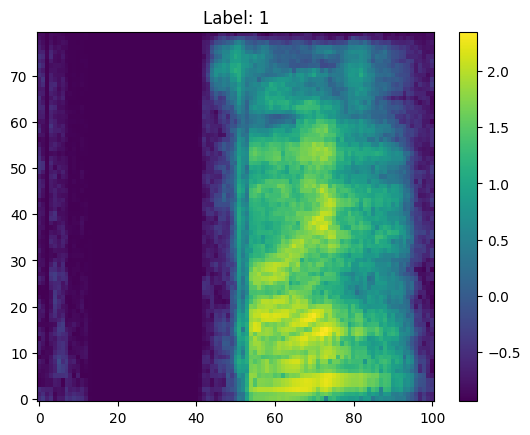

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the first feature (likely a spectrogram or similar)
plt.imshow(sample_feature.squeeze(0).numpy(), aspect='auto', origin='lower')
plt.title(f"Label: {sample_label}")
plt.colorbar()
plt.show()


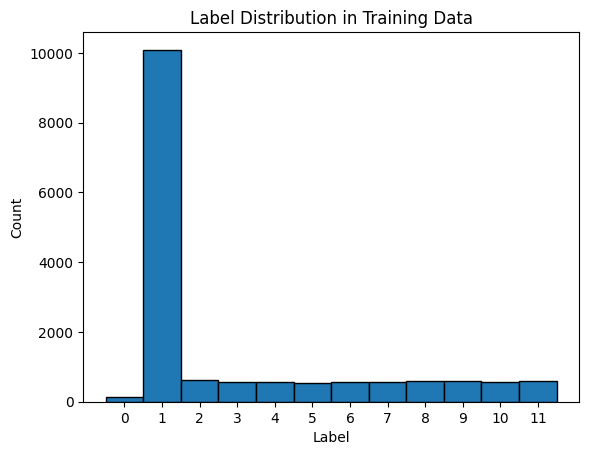

In [59]:
# Get all labels
all_labels = [train_dataset[i][1].item() for i in range(len(train_dataset))]

# Plot the label distribution
plt.hist(all_labels, bins=np.arange(min(all_labels), max(all_labels) + 2) - 0.5, edgecolor='black')
plt.xticks(np.arange(min(all_labels), max(all_labels) + 1))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution in Training Data")
plt.show()

In [60]:
# Calculate statistics on the features
all_features = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
mean = all_features.mean().item()
std = all_features.std().item()

print(f"Feature Mean: {mean}")
print(f"Feature Standard Deviation: {std}")

Feature Mean: -4.062086222944572e-09
Feature Standard Deviation: 0.999937891960144


In [61]:
!pip install sounddevice

In [62]:
import torchaudio
import sounddevice as sd

# Assuming sample_feature is your real-valued spectrogram
griffin_lim = torchaudio.transforms.GriffinLim(n_fft=158, n_iter=150)  # Adjust n_fft as per your spectrogram
waveform = griffin_lim(sample_feature)

# Play the reconstructed waveform using sounddevice
sd.play(waveform.squeeze(0).numpy(), samplerate=16000)  # Adjust the sample rate as needed
sd.wait()  # Wait until playback is finished


In [70]:
BATCH_SIZE = 128
N_CLASSES = 12

train, val, test, dset = setup_data()

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Iterate through one batch
for batch_features, batch_labels in train:
    print(f"Batch features shape: {batch_features.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")
    break

./speechcommands-5h_assignment/ exists..


/tmp/ipykernel_11140/1618205544.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.features = torch.load(features_path)
/tmp/ipykernel_11140/1618205544.py:10: FutureWa

FEATURES SHAPE: torch.Size([16000, 80, 101])
FEATURES SHAPE: torch.Size([2000, 80, 101])
FEATURES SHAPE: torch.Size([4890, 80, 101])
Number of training samples: 16000
Number of validation samples: 2000
Number of test samples: 4890
Batch features shape: torch.Size([128, 1, 80, 101])
Batch labels shape: torch.Size([128])


Transformer hyperparameters


In [8]:
MODEL_HPARAMS = {
    "input_res":[80, 101],   # FIXED
    "num_classes":N_CLASSES, # FIXED
    "patch_res":[80, 1],
    "mlp_dim":256,
    "dim":64,
    "heads":4,
    "dim_head":64//4,       # dim_head should be dim divided by number of heads
    "depth":4,
    "dropout": 0.1,
    "emb_dropout": 0.1
}

This is the PyTorch-Lightning Module implementation, which takes care of a lot of boilerplate code related to training for us.

In [9]:
class KWTLightning(pl.LightningModule):
  def __init__(self, hparams, mha_block=MHA):
    super().__init__()
    self.model = KWT(**hparams, mha_block=mha_block)

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.01)

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    preds = self.model(x)
    loss = nn.functional.cross_entropy(preds, y)
    acc = (preds.argmax(dim=-1) == y).float().mean()

    self.log("train_loss", loss)
    self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
    return loss

  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    preds = self.model(x)
    loss = nn.functional.cross_entropy(preds, y)
    acc = (preds.argmax(dim=-1) == y).float().mean()
    self.log('val_loss', loss)
    self.log("val_acc", acc, prog_bar=True, on_epoch=True)

  def test_step(self, batch, batch_idx):
    x, y = batch
    preds = self.model(x)
    loss = nn.functional.cross_entropy(preds, y)
    acc = (preds.argmax(dim=-1) == y).float().mean()
    self.log('test_loss', loss)
    self.log("test_acc", acc)

def create_pl(mha_block):
  kwt_pl = KWTLightning(MODEL_HPARAMS, mha_block)
  return kwt_pl

In [10]:
## This creates the PyTorch Lightning module which will be trained in cells that follow.
kwt_pl = create_pl(mha_block=MHA) 

In [11]:
trainer = pl.Trainer(accelerator="gpu", enable_checkpointing=False, max_epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [12]:
trainer.fit(kwt_pl, train_dataloaders=train, val_dataloaders=val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | KWT  | 211 K  | train
---------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.848     Total estimated model params size (MB)
115       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
trainer.test(kwt_pl, test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8034764528274536
        test_loss            0.615161657333374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.615161657333374, 'test_acc': 0.8034764528274536}]